本项目是为完成kaggle竞赛题(Dogs vs. Cats Redux: Kernels Edition)而作,题目地址：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
题目要求完成一个图片分类器，用于识别猫和狗，题目给出包含猫狗图片的训练集(25000张图)和测试集(12500张图)，自己搭建神经网络，通过训练集训练模型后预测测试集的结果。

In [1]:
import os
from PIL import Image,ImageOps
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

一、数据预处理  

1、读取train文件夹，并根据文件名添加相应标签，将其分割成训练集和验证集。

In [2]:
data_dir='./dataset/'
train_dir=os.path.join(data_dir,'train') #训练集原始文件夹
image_names=os.listdir(train_dir) #原始文件名
image_paths=[os.path.join(train_dir,fn) for fn in image_names] #原始文件路径
train_sets_dir=os.path.join(data_dir,'train_sets') #准备放训练集的新文件夹

In [58]:
'''
import shutil
if os.path.exists(train_sets_dir):
    shutil.rmtree(train_sets_dir)
    os.mkdir(train_sets_dir)
'''

'\nimport shutil\nif os.path.exists(train_sets_dir):\n    shutil.rmtree(train_sets_dir)\n    os.mkdir(train_sets_dir)\n'

定义一个图片过滤器，功能：1、去除图片的白色边缘，2、过滤掉像素小于12544的图片。

In [3]:
def image_filter(path):
    image=cv2.imread(path)[2:-2,2:-2]
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.inRange(image,np.array([215,215,215]),np.array([255,255,255]))
    pil_mask=Image.fromarray(mask)
    bbox=ImageOps.invert(pil_mask).getbbox()
    cropped_image=Image.fromarray(image).crop([*bbox])
    if cropped_image.size[0]*cropped_image.size[1]>12544:
        cropped_image.save(os.path.join(train_sets_dir,os.path.basename(path)))

清洗数据，并将数据保存至  './dataset/train_sets/'

In [ ]:
for path in image_paths: image_filter(path)

In [3]:
image_names=os.listdir(train_sets_dir) #清洗后的文件名
data_size=len(image_names)
print('%d pictures remaining after data cleaning.'%data_size)

24803 pictures remaining after data cleaning.


In [4]:
sample_size=int(data_size*0.8*0.5)

#把dog和cat分装到两个列表dogs和cats，并附加标签
dogs,cats=[],[]
for fn in image_names:
    dogs.append((os.path.join(train_sets_dir,fn),1)) if 'dog' in fn else cats.append((os.path.join(train_sets_dir,fn),0))
    
#分割训练集和验证集
train_dogs,valid_dogs=train_test_split(dogs,train_size=sample_size,random_state=18,shuffle=True)
train_cats,valid_cats=train_test_split(cats,train_size=sample_size,random_state=18,shuffle=True)
train_sets=train_dogs+train_cats
valid_sets=valid_dogs+valid_cats
train_size=len(train_sets)
valid_size=len(valid_sets)

print('train_sets: %d, including:%d dogs and %d cats.\nvalid_sets: %d, including:%d dogs and %d cats.'
      %(train_size,len(train_dogs),len(train_cats),valid_size,len(valid_dogs),len(valid_cats)))

train_sets: 19842, including:9921 dogs and 9921 cats.
valid_sets: 4961, including:2469 dogs and 2492 cats.


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2、创建transform，用于图片转换，为了确保两个模型输入的是同一张图片，我们不用任何随机裁剪、翻转。

In [5]:
transform={
#transforms for ResNet50
'resnet':transforms.Compose([transforms.Resize(224),
                             transforms.CenterCrop(224),
                             transforms.ToTensor(),
                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),

#transforms for Inception v3
'inception':transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}

3、定义图片转换函数path2input，用于从文件路径读取，到转换成适合模型维度的Tensor

In [6]:
#read the image, return Tensor for model input
def path2input(paths,transform):
    '''
    path: a batch of image path
    transform:transforms.Compose()
    '''
    return torch.cat(tuple(transform(Image.open(path)).unsqueeze(0) for path in paths))

4、给训练集和验证集分别创建DataLoader

In [12]:
train_batch=32 #训练集batch size
valid_batch=32 #验证集集batch size

#创建DataLoader
train_loader=torch.utils.data.DataLoader(train_sets,batch_size=train_batch,shuffle=True,num_workers=4,drop_last=True)
valid_loader=torch.utils.data.DataLoader(valid_sets,batch_size=valid_batch,shuffle=True,num_workers=4,drop_last=True)

5、展示转换后的图像，datasets为包含文件路径和标签的列表集合，transform为要使用的transform组合。

In [8]:
#定义展示转换图像的函数
def trans_images_show(datasets,transform):
    trans4plot=[torch.sigmoid(transform(Image.open(path))).permute(1,2,0) for path,_ in datasets]
    size=len(trans4plot)
    fig,ax=plt.subplots(int(size/2),2,figsize=(15,size*2))
    for i in range(size):
        row,col=(i,0) if i<size/2 else (int(i-size/2),1)
        ax[row,col].imshow(trans4plot[i])

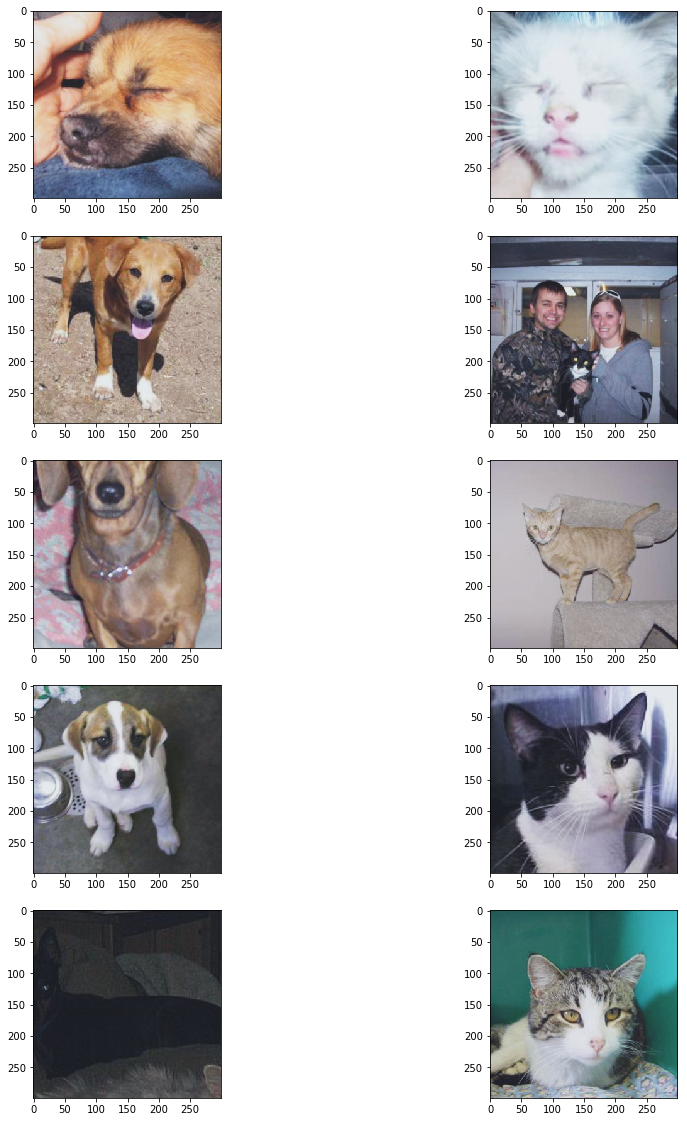

In [9]:
#展示转换后的图像
trans_images_show(train_dogs[:5]+train_cats[:5],transform['inception'])

二、搭建神经网络  

1、本项目使用迁移学习的方式来训练模型。选择表现较好的inception_v3，并修改其fc层，定义损失函数和优化函数。

In [13]:
#用于替换预训练模型的fc层
class FC(nn.Module):
    def __init__(self):
        super(FC,self).__init__()
        
    def forward(self,x):
        return x

#定义混合模型
class FusionNet(nn.Module):
    def __init__(self):
        super(FusionNet,self).__init__()
        
        self.resnet=models.resnet50(pretrained=True)
        self.resnet.fc=FC()
        for param in self.resnet.parameters():
            param.requires_grad=False
        
        self.inception=models.inception_v3(pretrained=True)
        self.inception.aux_logits=False
        self.inception.fc=FC()
        for param in self.inception.parameters():
            param.requires_grad=False
            
        self.classifier=nn.Sequential(nn.BatchNorm1d(4096),
                                      nn.Linear(4096,1024),
                                      nn.Linear(1024,2))
        
    def forward(self,res_input,inc_input):
        res_output=self.resnet(res_input)
        inc_output=self.inception(inc_input)
        x=torch.cat((res_output,inc_output),dim=1)
        x=self.classifier(x)
        return x

In [14]:
model=FusionNet()

#为在GPU上训练做准备
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model=model.to(device)

2、定义损失函数

In [15]:
criterion=nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

3、定义优化函数  

可选择是否训练inception_v3第七层参数。  
本项目选择先用较大的learning rate=0.004训练model.fc和model.AuxLogits.fc层，再打开[Mixed_7a，Mixed_7b，Mixed_7c]的梯度追踪，用较小的学习率(0.0012)进行第七层和fc层的finetune

In [11]:
optimizer=torch.optim.SGD(model.classifier.parameters(),lr=0.0012,momentum=0.92)
#scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=2)

In [16]:
optimizer=torch.optim.Adam(model.classifier.parameters())

In [12]:
'''
#训练第七层的参数
for layer in [model.Mixed_7a,model.Mixed_7b,model.Mixed_7c]:
    for param in layer.parameters():
        param.requires_grad=True
'''

In [14]:
'''
optimizer=torch.optim.SGD([{'params':model.Mixed_7a.parameters()},
                           {'params':model.Mixed_7b.parameters()},
                           {'params':model.Mixed_7c.parameters()},
                           {'params':model.fc.parameters()},
                           {'params':model.AuxLogits.fc.parameters()}],
                          lr=0.00058,momentum=0.95)
                          '''

三、训练网络  

1、准备训练参数

In [17]:
epochs=8
every=4 #每every次，暂停训练，进行一次验证
epoch_dict={'loss':{'train':[],'valid':[]},'acc':{'train':[],'valid':[]}}
running={'loss':{'train':[],'valid':[]},'acc':{'train':[],'valid':[]}}

2、训练并验证模型，观察loss、accuracy输出、每轮epoch保存一次模型，万一过拟合可以回溯。

In [19]:
for epoch in range(1,epochs+1):
    count=0
    running_loss=0
    running_acc=0
    valid_iter=iter(valid_loader)
    
    #train
    model.train()
    for paths,labels in train_loader:
        res_input=path2input(paths,transform['resnet'])
        inc_input=path2input(paths,transform['inception'])
        #res_input=res_input.to(device)
        #inc_input=inc_input.to(device)
        optimizer.zero_grad() #计算梯度前清空历史梯度
        output=model(res_input, inc_input)
        #labels=labels.to(device)
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item() #累计loss
        train_acc=accuracy_score(torch.argmax(output,dim=1),labels)
        running_acc+=train_acc #累计accuracy

        count+=1
        print('epoch:%d, training:%d/%d, loss:%.6f, accuracy:%.4f\r'%(epoch,train_batch*count,train_size,loss,train_acc),end='')
        if count%every==0:
            average_loss=running_loss/every #every个batch的平均loss
            average_acc=running_acc/every #every个batch的平均accuracy
            print('epoch:%d, training:%d/%d, average_loss:%.6f, accuracy:%.4f\r'
                  %(epoch,train_batch*count,train_size,average_loss,average_acc))
            running['loss']['train'].append(average_loss)
            running['acc']['train'].append(average_acc)
            running_loss=0
            running_acc=0
            
            #validate
            model.eval()
            paths,labels=next(valid_iter)
            res_input=path2input(paths,transform['resnet'])
            inc_input=path2input(paths,transform['inception'])
            #res_input=res_input.to(device)
            #inc_input=inc_input.to(device)
            output=model(res_input, inc_input)
            #labels=labels.to(device)
            loss=criterion(output,labels)
            valid_acc=accuracy_score(torch.argmax(output,dim=1),labels)
            print('epoch:%d, validation:%d/%d, loss:%.6f, accuracy:%.4f'%(epoch,valid_batch*count/every,valid_size,loss,valid_acc))
            running['loss']['valid'].append(loss.item())
            running['acc']['valid'].append(valid_acc)
            model.train()
    e_count=int(count/every)
    e_train_loss=sum(running['loss']['train'][-e_count:])/e_count
    e_train_acc=sum(running['acc']['train'][-e_count:])/e_count
    e_valid_loss=sum(running['loss']['valid'][-e_count:])/e_count
    e_valid_acc=sum(running['acc']['valid'][-e_count:])/e_count
    print('\nepoch %d, average training loss:%.4f ; training accuracy:%.4f'%(epoch,e_train_loss,e_train_acc))
    print('\nepoch %d, average validation loss:%.4f ; validation accuracy:%.4f'%(epoch,e_valid_loss,e_valid_acc))
    epoch_dict['loss']['train'].append(e_train_loss)
    epoch_dict['loss']['valid'].append(e_valid_loss)
    epoch_dict['acc']['train'].append(e_train_acc)
    epoch_dict['acc']['valid'].append(e_valid_acc)
    torch.save(model.state_dict(),'./FusionNet-%s.pkl'%epoch)
    #scheduler.step()
#print(epoch_dict)

OSError: [Errno 12] Cannot allocate memory

3、绘制训练误差和验证误差

Text(0.5,1,'epoch accuracy')

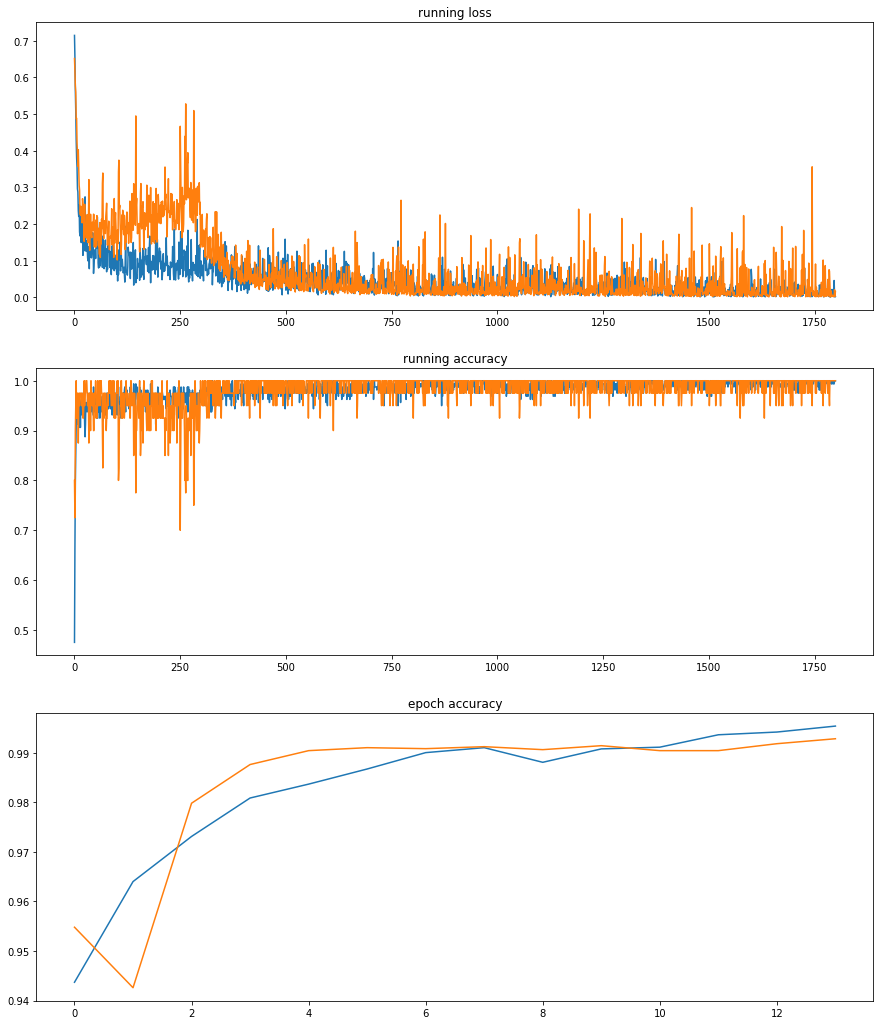

In [44]:
fig,ax=plt.subplots(3,1,figsize=(15,18))

ax[0].plot(running['train']['loss'])
ax[0].plot(running['valid']['loss'])
ax[0].set_title('running loss')

ax[1].plot(running['train']['acc'])
ax[1].plot(running['valid']['acc'])
ax[1].set_title('running accuracy')

ax[2].plot(epoch_acc['train'])
ax[2].plot(epoch_acc['valid'])
ax[2].set_title('epoch accuracy')

保存模型参数

In [54]:
# save_model='Fusion-1230-0.pkl'
# torch.save(model.state_dict(),save_model)

读取模型参数

In [59]:
#load_model='./Inc_1224-1.pkl'
#model.load_state_dict(torch.load(load_model))

三、预测测试集  

1、准备测试集数据

In [18]:
import pandas as pd

test_dir=os.path.join(data_dir,'test')
test_images=os.listdir(test_dir)
test_sets=[(os.path.join(test_dir,fn),int(fn[:-4])) for fn in test_images] #test_sets数据类型为(image_path,ID)
test_size=len(test_sets)
print('test_sets: %d'%(test_size))

test_sets: 12500


2、预测图片

先将结果放进DataFrame

In [19]:
#创建一个空的带header的DataFrame
df=pd.DataFrame(columns=['id','label'])

#test
count=0
model.eval()
test_loader=torch.utils.data.DataLoader(test_sets,batch_size=50)
for paths,ID in test_loader:
    res_input=path2input(paths,transform['resnet'])
    inc_input=path2input(paths,transform['inception'])
    #res_input=res_input.to(device)
    #inc_input=inc_input.to(device)
    output=model(res_input, inc_input)
    dog_probs=F.softmax(output,dim=1).data[:,1] #图片是狗的概率
    df=df.append(pd.DataFrame({'id':ID,'label':dog_probs}),ignore_index=True)
    count+=1
    print('processing: %d/%d\r'%(count*50,test_size),end='')

KeyboardInterrupt: 

3、依id排序，将DataFrame的数据写入csv文件

In [61]:
csv_file='submission.csv'
df.sort_values(by='id',inplace=True)
df.to_csv(csv_file,index=False)
print(df)

          id         label
8485       1  9.912005e-01
8403       2  9.975492e-01
8316       3  9.815010e-01
10466      4  9.964597e-01
1464       5  2.859006e-06
7874       6  3.365921e-06
11042      7  1.245270e-08
3874       8  9.063249e-05
8647       9  2.156004e-09
6454      10  1.565640e-07
1070      11  8.896191e-05
906       12  9.973272e-01
11819     13  8.508807e-06
10514     14  1.961484e-04
9988      15  1.233375e-04
1546      16  4.235403e-05
2307      17  9.161524e-01
11742     18  9.963344e-01
12051     19  2.196015e-06
3798      20  2.129358e-06
10554     21  9.961259e-01
5293      22  3.017754e-08
8056      23  9.928426e-01
9138      24  9.896441e-01
11469     25  1.010580e-07
8466      26  9.005311e-01
4351      27  9.975805e-01
4670      28  1.863669e-08
10061     29  4.017879e-02
3125      30  9.717417e-01
...      ...           ...
9374   12471  9.956501e-01
4655   12472  9.777309e-01
10549  12473  1.863660e-03
7234   12474  3.112509e-08
607    12475  4.229198e-08
1

四、评分结果
采用Inception_v3预训练模型，修改fc层，训练第七层以及fc、AuxLogits.fc层参数，在kaggle最好成绩为 Public Score：0.06254  
附模型及预测结果